In [1]:
import numpy as np
import scipy as sp
import numpy.linalg as la
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spsla
import matplotlib.pyplot as plt
import sys, time, os
import cvxpy as cvx
import cvxopt as opt
import krypy as kp
sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import problems, projection, optimize, util
from tomo1D import blur_1d
from tomo2D import blur_2d

## load data

In [3]:
# load data
X = np.load('../../data/HOTomoMats/Amat.npy')
M = np.load('../../data/HOTomoMats/Mmat.npy')
sb = np.load('../../data/HOTomoMats/sb.npy')
lams = np.load('../../data/HOTomoMats/lambdas.npy')
Kb_diag = np.load('../../data/HOTomoMats/DiagKb.npy')
Kb = np.diag(Kb_diag)

# convert to sparse / vector
X = sps.csr_matrix(X)
M = M*1
M = sps.csr_matrix(M)
Kb = sps.csr_matrix(Kb)
sb = sb.reshape(len(sb),1)

# set sizes
k = M.shape[0]
n_1, n_2 = 49, 50 # 35, 70
n = n_1 * n_2
m = Kb.shape[0]

# print sizes
print('k: %s' % k)      # roi
print('n_1: %s' % n_1)  # n rows
print('n_2: %s' % n_2)  # n cols
print('n: %s' % n)      # image space dim
print('m: %s' % m)      # data space dim
print(type(X), 'X size: (%s,%s)' % X.shape, 'nnz: %s' % X.count_nonzero())
print(type(M), 'M size: (%s,%s)' % M.shape, 'M', 'nnz: %s' % M.count_nonzero())
print(type(Kb), 'Kb size: (%s,%s)' % Kb.shape, 'Kb', 'nnz: %s' % Kb.count_nonzero())
print(type(sb), 'sb size: (%s,%s)' % sb.shape, 'sb', 'nnz: %s' % np.count_nonzero(sb))

k: 30
n_1: 49
n_2: 50
n: 2450
m: 1050
(<class 'scipy.sparse.csr.csr_matrix'>, 'X size: (1050,2450)', 'nnz: 62307')
(<class 'scipy.sparse.csr.csr_matrix'>, 'M size: (30,2450)', 'M', 'nnz: 30')
(<class 'scipy.sparse.csr.csr_matrix'>, 'Kb size: (1050,1050)', 'Kb', 'nnz: 1050')
(<type 'numpy.ndarray'>, 'sb size: (1050,1)', 'sb', 'nnz: 312')


In [ ]:
def extendM(M=None, sp=35, lo=19, hi=19):
    M = M.A
    n = M.shape[1]
    
    idxs = []
    for j in range(n):
        if sum(M[:,j]) == 1:
            idxs.append(j)
    ll = idxs[0]
    hh = idxs[-1]
    for i in range(1,lo+1):
        new = np.zeros(n).reshape(1,n)
        new[:,ll-i*sp] = 1.
        M = np.vstack((new,M))
    for i in range(1,hi+1):
        new = np.zeros(n).reshape(1,n)
        new[:,ll+i*sp] = 1.
        M = np.vstack((M,new))
    
    return M

In [ ]:
M = extendM(M=M)
M = sps.csr_matrix(M)
M.shape

In [4]:
# load regularization
lams = np.append(lams, 1e-6) # [1e-6, 1e-8, 1e-10, 1e-12, 1e-14, 1e-16, 1e-28])
print('lams: %s' % lams)

lams: [  9.08303756e+02   9.08303756e+00   9.08303756e-02   9.08303756e-04   1.00000000e-06]


## compute rxns

In [5]:
# construct R
Rs = []
for lam in lams:
    Rs.append(spsla.spsolve(X.T.dot(X) + lam*sps.eye(n), X.T, use_umfpack=True))

## set params

In [35]:
tol = 1e-10  # rcond for pinv; stopping criteria for ipm / minres
niter = 100
idx = 1      # 3 = Sean's weakest; 0 = strongest

# test specific lambda
lam = lams[idx]
R = Rs[idx]
print('testing lambda: %s' % lam)

testing lambda: 9.08303755914


In [37]:
# cholesky of K
K_12 = sps.spdiags([np.sqrt(x) for x in Kb_diag], diags=0, m=m, n=m)      # cholesky
K_12_1 = sps.spdiags([1./x for x in K_12.diagonal()], diags=0, m=m, n=m)  # inverse cholesky

In [38]:
# set matrices
MTM = M.T.dot(M)
G = X.T.dot(Kb).dot(X)
Z = M.T.dot(M)
XTXL = X.T.dot(X) + lam*sps.eye(n)
Y = (sps.eye(n) - Z)
A = (sps.eye(n) - Z).dot(X.T.dot(X) + lam*sps.eye(n))
c = X.T.dot(sb)
LHS = M.dot(R).dot(Kb).dot(R.T).dot(M.T)
RHS = M.dot(R).dot(sb)

## solve direct

2.73970459482


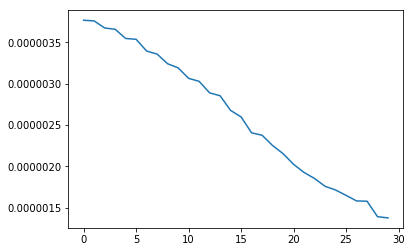

In [39]:
u,s,v = la.svd(LHS.A)
print(la.cond(LHS.A))
plt.plot(s)
plt.show()

In [40]:
# solve direct
w_d,_,_ = util.direct_solve(Kb=Kb, R=R, M=M, B=None, sb=sb, sparse=True)
w_d_pinv = la.pinv(LHS.A, rcond=tol).dot(RHS)

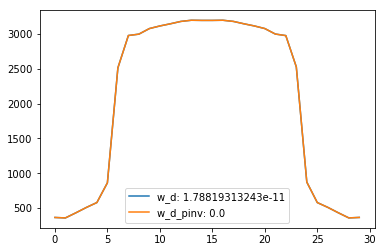

In [41]:
# check solution
plt.plot(w_d, label='w_d: %s'%(la.norm(w_d-w_d_pinv)))
plt.plot(w_d_pinv, label='w_d_pinv: %s'%(la.norm(w_d_pinv-w_d_pinv)))
plt.legend()
plt.show()
plt.close()

## factor for ipm

In [ ]:
G = X.T.dot(Kb).dot(X)
print(G.shape)
Ginv = spsla.inv(G)

In [ ]:
np.max(Ginv.A)
np.min(Ginv.A)

In [ ]:
plt.plot(Ginv.A[1,])
plt.show()

In [ ]:
plt.imshow(Ginv.dot(G).A)
plt.show()

In [ ]:
Gpinv = la.pinv(G.A)

In [ ]:
np.max(Gpinv)
np.min(Gpinv)

In [ ]:
plt.plot(Gpinv[1,])
plt.show()

In [ ]:
Gpinv.shape

In [ ]:
plt.imshow(Gpinv)
plt.show()

In [ ]:
Gpinv = sps.csr_matrix(Gpinv)

In [ ]:
I = Gpinv.dot(G)

In [ ]:
plt.imshow(I.A)
plt.show()

In [ ]:
x = np.random.randn(2450)

In [ ]:
M.T.dot(M).dot((np.eye(2450) - M.T.dot(M))).dot(x)

In [ ]:
Z_condnum = la.cond(Z.A)

In [ ]:
Zinv = la.inv(Z.A)

In [ ]:
x = np.random.rand(n)

In [ ]:
U,S,V = la.svd(A.A)

In [ ]:
X.shape

In [ ]:
M.shape

In [ ]:
la.matrix_rank(X.A)

In [ ]:
np.sum(A != A.T)

In [42]:
# initialize problem
u = cvx.Variable(n)
# w = cvx.Variable(n)
obj = cvx.Minimize( cvx.norm(K_12*X*u - K_12_1*sb))
constr = [Y*w == float(0)]
# constr += [(X.T.dot(X) + lam*sps.eye(n))*u == w]
prob = cvx.Problem(obj, constr)

print(K_12.shape)
print(X.shape)
print(K_12_1.shape)
print(sb.shape)

mosek_params = {'MSK_IPAR_OPTIMIZER':2}  # 2: conic (http://docs.mosek.com/8.0/capi/constants.html#optimizertype)
mosek_params['MSK_DPAR_INTPNT_CO_TOL_REL_GAP'] = 1e-9    # doesn't seem to work with `tol` tolerance; breaks at 1e-14
mosek_params['MSK_IPAR_INTPNT_MAX_ITERATIONS'] = niter    # doesn't seem to work...
mosek_params['MSK_IPAR_PRESOLVE_USE'] = 0 # setting MSK_PRESOLVE_MODE_OFF to off

(1050, 1050)
(1050, 2450)
(1050, 1050)
(1050, 1)


In [43]:
# solve problem
result = prob.solve(solver='MOSEK', mosek_params=mosek_params, verbose=True)
u_cvx = spsla.spsolve(XTXL,u.value)
w_cvx = util.calc_hot(X=X, B=None, lam=lam, M=M, u=u_cvx, ESI=False)

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3501            
  Cones                  : 1               
  Scalar variables       : 5952            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 3501            
  Cones                  : 1               
  Scalar variables       : 5952            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 8               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 3501
Optimizer  - Cones                  : 2
Optimizer  - Scalar variables 

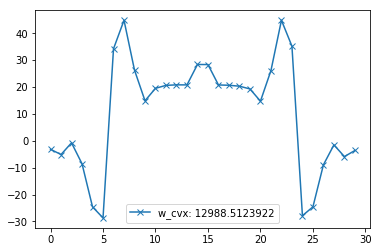

In [45]:
# check solution
plt.plot(w_cvx, label='w_cvx: %s'%(la.norm(w_cvx-w_d_pinv)), marker='x')
plt.plot(w_d, label='w_d: %s'%(la.norm(w_d-w_d_pinv)))
plt.plot(w_d_pinv, label='w_d_pinv: %s'%(la.norm(w_d_pinv-w_d_pinv)), marker='o', markersize=3)
plt.legend()
plt.show()
plt.close()

In [ ]:
ESI_A, ESI_b = util.gen_ESI_system(X=X, Kb=Kb, B=None, M=M, lam=lam, sb=sb)

In [ ]:
# solve minres
u_m, _, us_m, mr_m, t_m, tt_m = spsla.minres_track(A=ESI_A, b=ESI_b, tol=tol, maxiter=niter)
u_m = u_m.reshape(len(u_m),1)
w_m = util.calc_hot(X=X, B=None, lam=lam, M=M, u=u_m, ESI=True)

In [ ]:
# check solution
plt.plot(w_m, label='w_m: %s'%(la.norm(w_m-w_d_pinv)))
# plt.plot(w_d, label='w_d: %s'%(la.norm(w_d-w_d_pinv)))
# plt.plot(w_d_pinv, label='w_d_pinv: %s'%(la.norm(w_d_pinv-w_d_pinv)))
plt.legend()
plt.show()
plt.close()

## JAKES IPM

In [ ]:
import numpy as np
import matlab.engine
eng = matlab.engine.start_matlab()

In [ ]:
def ipm(x0=None, s0=None, y0=None, z0=None, \
        mu0=None, sigma=None, tau=None, \
        niter=10):

    ## set initial parameters
    if x0 is None: x0 = np.array([-1.71, 1.59, 1.82, -0.763, -0.763])
    if s0 is None: s0 = np.array([0.5, 0.5])
    if y0 is None: y0 = np.array([0.5, 0.5, 0.5])
    if z0 is None: z0 = np.array([0.5, 0.5])
    if mu0 is None: mu0 = 2.
    if sigma is None: sigma = 0.5     # python only
    if tau is None: tau = 0.995       # python only
    err = 1e6                         # python only

    ## prepare for iterations
    x = x0
    s = s0
    y = y0
    z = z0
    mu = mu0                           # python only

    ## solver interior Newton systems
    for k in range(niter):
        print("==== iteration: {:d} ================================".format(k))

        ## prepare current iterate to MATLAB
        x = matlab.double([q for q in x])
        s = matlab.double([q for q in s])
        y = matlab.double([q for q in y])
        z = matlab.double([q for q in z])
        inner = 0

        ## determine step
        while err > mu:
            ## setup and solve Newton System
            out = eng.ntsys(x, s, y, z, mu, nargout=4)
            [J, h, p, err] = [np.array(o) for o in out]
            ## reformatting
            p_x = p[0:5]
            p_s = p[5:7]
            p_y = p[7:10]
            p_z = p[10:12]
            x = np.array(x).reshape(5,1)
            s = np.array(s).reshape(2,1)
            y = np.array(y).reshape(3,1)
            z = np.array(z).reshape(2,1)
            ## step length
            a = np.linspace(0.,1., 100)
            a_s = a[max(np.where(s[0] + a*p_s >= (1.-tau)*s[0])[0])]
            a_z = a[max(np.where(z[0] + a*p_z[0][0] >= (1.-tau)*z)[0])]
            ## updates
            x += a_s*p_x
            s += a_s*p_s[0]
            y += a_z*p_y
            z += a_z*p_z[0]
            ## prepare current information for MATLAB
            x = matlab.double([float(q) for q in x])
            s = matlab.double([float(q) for q in s])
            y = matlab.double([float(q) for q in y])
            z = matlab.double([float(q) for q in z])
            ## compute error
            out = eng.ntsys(x, s, y, z, mu, nargout=4)
            [_, _, _, err] = [np.array(o) for o in out]
            ## tracking
            inner += 1
            print(x)
            print(err)
            print(inner)

        ## adjust mu
        mu *= sigma

    return x


In [ ]:
x = ipm()
print(x)

In [ ]:
eng.ipm_example()

In [ ]:
la.matrix_rank(A.A)

In [20]:
MTM = M.T.dot(M)

In [ ]:
la.matrix_rank(MTM.A)

In [ ]:
plt.imshow(MTM.A)
plt.show()

In [ ]:
MTM

In [ ]:
sps.find(MTM)

In [21]:
U,S,V = la.svd(MTM.A)

In [ ]:
sps.find(u)

In [ ]:
sps.find(v)

In [ ]:
plt.imshow(v)
plt.show()

In [ ]:
P_kA = v.dot(v.T)

In [ ]:
plt.imshow(P_kA)
plt.show()

In [ ]:
for i in range(3):
    print(len(sps.find(P_kA)[i]))

In [ ]:
x = np.random.rand(n)

In [ ]:
L, U = sla.lu(MTM.A, permute_l=True)

In [ ]:
plt.imshow(U)
plt.show()

In [ ]:
np.sum(L!=sps.eye(n))

In [ ]:
x0 = la.solve(A.A,np.zeros(n))

In [ ]:
V = v.T.dot(v)

In [ ]:
V.shape

In [ ]:
pka = sps.eye(n) - A.dot(A.T.dot(A))

In [22]:
def null(A, eps=1e-15):
    u, s, vh = sp.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = sp.compress(null_mask, vh, axis=0)
    return sp.transpose(null_space)

In [ ]:
t = np.matrix([
...     [2,3,5],
...     [-4,2,3],
        [0,0,0]
...     ])  

In [ ]:
null(t)

In [23]:
N=null(MTM.A)

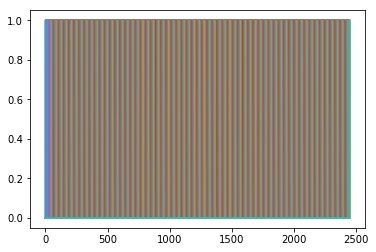

In [24]:
plt.plot(N)
plt.show()

In [ ]:
N.shape

In [ ]:
A.dot(x[:,1])